<a href="https://colab.research.google.com/github/GlauberRuan/skin-cancer-detection-cnn/blob/main/skin_cancer_cnn_classifier_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer9-classesisic' dataset.
Path to dataset files: /kaggle/input/skin-cancer9-classesisic


In [ ]:
# Preparação do ambiente
!pip install tensorflow keras matplotlib scikit-learn opencv-python


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201, ResNet50, Xception, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Definições base
NUM_CLASSES = 9
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

import kagglehub

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)
# Ajuste o caminho conforme o seu download do Kaggle/dataset
DATA_DIR = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/'

# Dicionários para salvar os modelos e seus históricos de treinamento
all_models = {}
all_histories = {}
EPOCHS = 60 # Ajuste para o número de épocas usado no artigo original

Using Colab cache for faster access to the 'skin-cancer9-classesisic' dataset.
Path to dataset files: /kaggle/input/skin-cancer9-classesisic


In [ ]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.20
)

test_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
# Pré-processamento e data augmentation

"""
O artigo define as seguintes transformações:
rescale 1/255
shear=0.2
horizontal e vertical flip
zoom range
target_size = (176,176)
"""

# Gerador de Treinamento
train_generator = train_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Gerador de Validação
validation_generator = train_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Gerador de Teste
test_generator = test_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"Classes carregadas: {class_names}")

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Classes carregadas: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# Callbacks

"""
O artigo utiliza early stopping baseado em val_loss
ReduceLROnPlateau com fator 0.1
"""

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5
)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True
)


In [ ]:
# Criando os modelos do artigo

"""
Os autores testaram 4 modelos:
- DenseNet201
- ResNet50
- Xception
- MobileNetV2

Todos com:
include_top=False
input_shape=(224,224,3)
global average pooling
Dense layers com LeakyReLU
Dropout (para evitar overfitting)
"""

def build_model(base, name):
  base_model = base(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Congela as camadas do modelo base como no artigo
  for layer in base_model.layers:
      layer.trainable = False

  # Adiciona as novas camadas (Top Layers)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)

  # Camada de Saída para 9 classes com Softmax ---
  predictions = Dense(NUM_CLASSES, activation='softmax')(x)

  # Cria o modelo final
  model = Model(inputs=base_model.input, outputs=predictions, name=name)

  # Compilação com Categorical Crossentropy ---
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  return model



In [ ]:
models_to_test = {
  'DenseNet201': DenseNet201,
  'MobileNetV2': MobileNetV2,
  'ResNet50': ResNet50,
  'Xception': Xception
}

for name, base_fn in models_to_test.items():
  print(f"\n--- Treinando {name} ---")

  # Constrói o modelo
  model = build_model(base_fn, name)

  # Treina e salva o histórico
  history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // BATCH_SIZE,
      verbose=1
  )

  # Salva o modelo e o histórico
  all_models[name] = model
  all_histories[name] = history

  # Avaliação
  loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=0)
  print(f"Acurácia final de teste para {name}: {accuracy:.4f}")


--- Treinando DenseNet201 ---
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.3231 - loss: 1.9544 - val_accuracy: 0.4183 - val_loss: 1.5725
Epoch 2/60
 1/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.4062 - loss: 1.5125

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.4062 - loss: 1.5125 - val_accuracy: 0.4255 - val_loss: 1.5349
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 738ms/step - accuracy: 0.4617 - loss: 1.4892 - val_accuracy: 0.4760 - val_loss: 1.4290
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.6562 - loss: 1.0122 - val_accuracy: 0.4832 - val_loss: 1.4285
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 735ms/step - accuracy: 0.5386 - loss: 1.3118 - val_accuracy: 0.4856 - val_loss: 1.4125
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.6562 - loss: 1.2033 - val_accuracy: 0.4928 - val_loss: 1.4114
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 728ms/step - accuracy: 0.5517 - loss: 1.2614 - val_accuracy: 0.4784 - val_loss: 1.4172
Epoch 8/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.5625 - loss: 1.0757 - val_accuracy: 0.4760 - val_loss: 1.4163
Epoch 9/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 726ms/step - accuracy: 0.5702 - loss: 1.2480 - val_accuracy: 0.5048 - 


--- Treinando ResNet50 ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 889ms/step - accuracy: 0.1822 - loss: 2.3123 - val_accuracy: 0.1947 - val_loss: 2.0131
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.1250 - loss: 2.1739 - val_accuracy: 0.2043 - val_loss: 1.9975
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 734ms/step - accuracy: 0.1976 - loss: 2.0623 - val_accuracy: 0.2091 - val_loss: 2.0086
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.2188 - loss: 2.0600 - val_accuracy: 0.1971 - val_loss: 2.0116
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 727ms/step - accuracy: 0.1818 - loss: 2.0435 - val_accuracy: 0.1923 - val_loss: 2.0170
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.1875 - loss: 1.9525 - val_accuracy: 0.1995 - val_loss: 2.0202
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 731ms/step - accuracy: 0.1883 - loss: 2.0628 - val_accuracy: 0.2067 - val_loss: 2.0157
Epoch 8/60
56/56 ━━━━


--- Treinando Xception ---
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2679 - loss: 2.0292 - val_accuracy: 0.3870 - val_loss: 1.6152
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.5000 - loss: 1.3980 - val_accuracy: 0.4111 - val_loss: 1.5935
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 724ms/step - accuracy: 0.4149 - loss: 1.6281 - val_accuracy: 0.4615 - val_loss: 1.4868
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.6875 - loss: 1.1994 - val_accuracy: 0.4639 - val_loss: 1.5108
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 737ms/step - accuracy: 0.4883 - loss: 1.4875 - val_accuracy: 0.4784 - val_loss: 1.4901
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.4375 - loss: 1.6018 - val_accuracy: 0.4615 - val_loss: 1.5324
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 740ms/step - accuracy: 0.5197 - loss: 1.4112 - val_accuracy: 0.4519 - val_loss: 1.5229
Epoch 8/60
56/56 ━━━━━━━


--- Treinando MobileNetV2 ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 986ms/step - accuracy: 0.2534 - loss: 2.3163 - val_accuracy: 0.4111 - val_loss: 1.5864
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 326ms/step - accuracy: 0.3438 - loss: 1.8787 - val_accuracy: 0.3990 - val_loss: 1.6120
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 697ms/step - accuracy: 0.4048 - loss: 1.6768 - val_accuracy: 0.3990 - val_loss: 1.5833
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.2188 - loss: 1.7755 - val_accuracy: 0.4279 - val_loss: 1.5648
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 702ms/step - accuracy: 0.4487 - loss: 1.5501 - val_accuracy: 0.4615 - val_loss: 1.5234
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.4375 - loss: 1.5219 - val_accuracy: 0.4423 - val_loss: 1.5466
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 697ms/step - accuracy: 0.4953 - loss: 1.4349 - val_accuracy: 0.4712 - val_loss: 1.5277
Epoch 8/60
56/56 ━━

In [ ]:
def plot_history(history, model_name):
  """Plota as curvas de Acurácia e Perda (Loss) do treinamento e validação."""

  plt.figure(figsize=(15, 6))

  # Curva de Acurácia
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
  plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
  plt.title(f'Curva de Acurácia - {model_name}')
  plt.xlabel('Época')
  plt.ylabel('Acurácia')
  plt.legend()
  plt.grid(True)

  # Curva de Perda (Loss)
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Perda de Treinamento')
  plt.plot(history.history['val_loss'], label='Perda de Validação')
  plt.title(f'Curva de Perda (Loss) - {model_name}')
  plt.xlabel('Época')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def plot_confusion_matrix(model, test_generator, class_names, model_name):
  """Calcula e plota a Matriz de Confusão."""

  test_generator.reset()

  # 1. Obter Previsões e Rótulos Reais
  # Previsão das probabilidades
  Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
  # Resultado da previsão é o índice da classe com maior probabilidade
  y_pred = np.argmax(Y_pred, axis=1)

  # Rótulos verdadeiros
  y_true = test_generator.classes

  # 2. Ajuste de tamanho (segurança) e Cálculo da Matriz de Confusão
  y_true = y_true[:len(y_pred)]
  cm = confusion_matrix(y_true, y_pred)

  # 3. Plotar
  plt.figure(figsize=(12, 10))
  sns.heatmap(
    cm,
    annot=True,
    fmt='g', # Formato 'g' para números inteiros
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
  )
  plt.title(f'Matriz de Confusão - {model_name}')
  plt.xlabel('Classes Preditas')
  plt.ylabel('Classes Reais')
  plt.show()


--- Geração das Curvas de Desempenho (Acurácia/Loss) ---


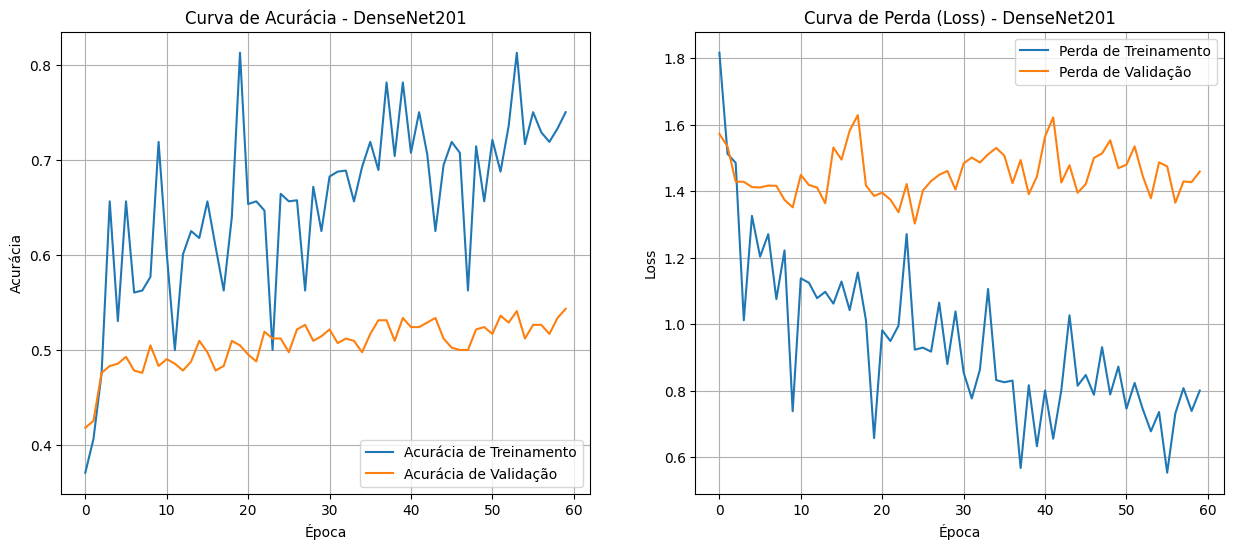

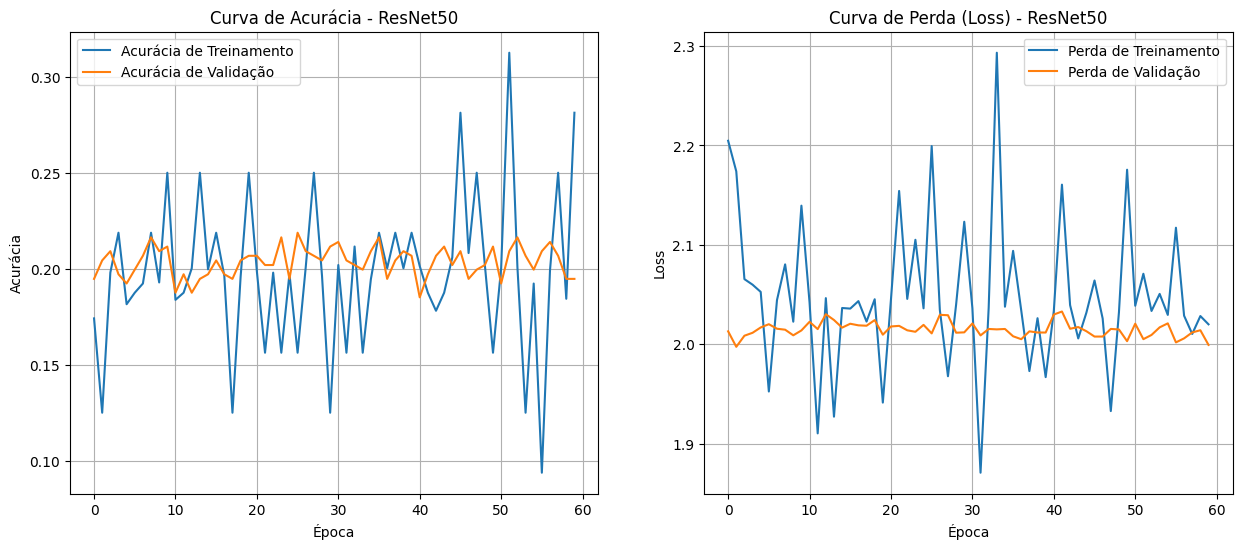

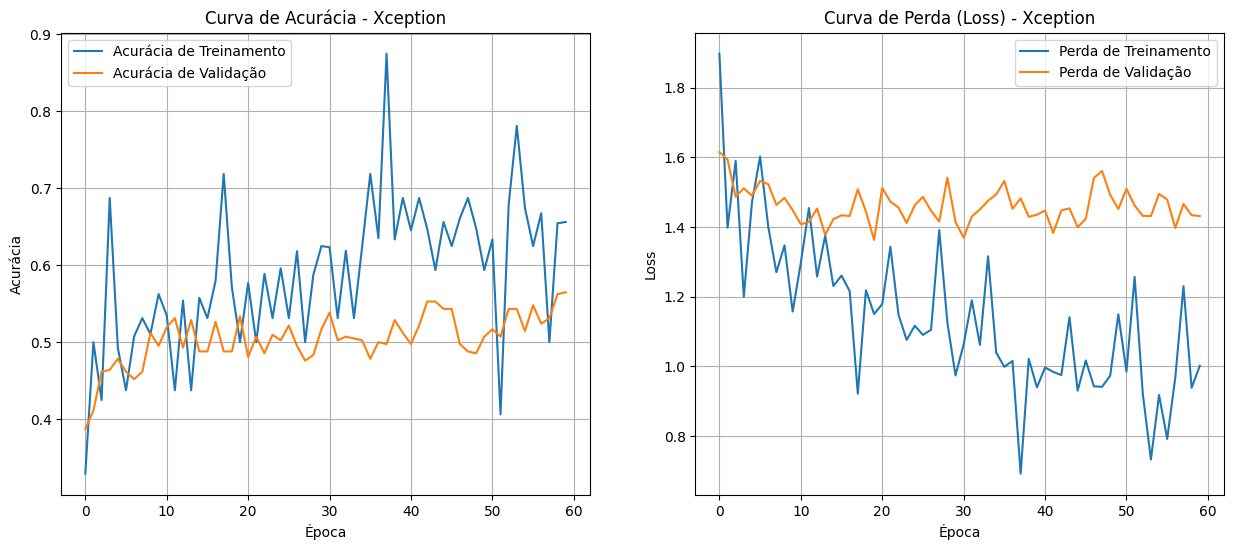

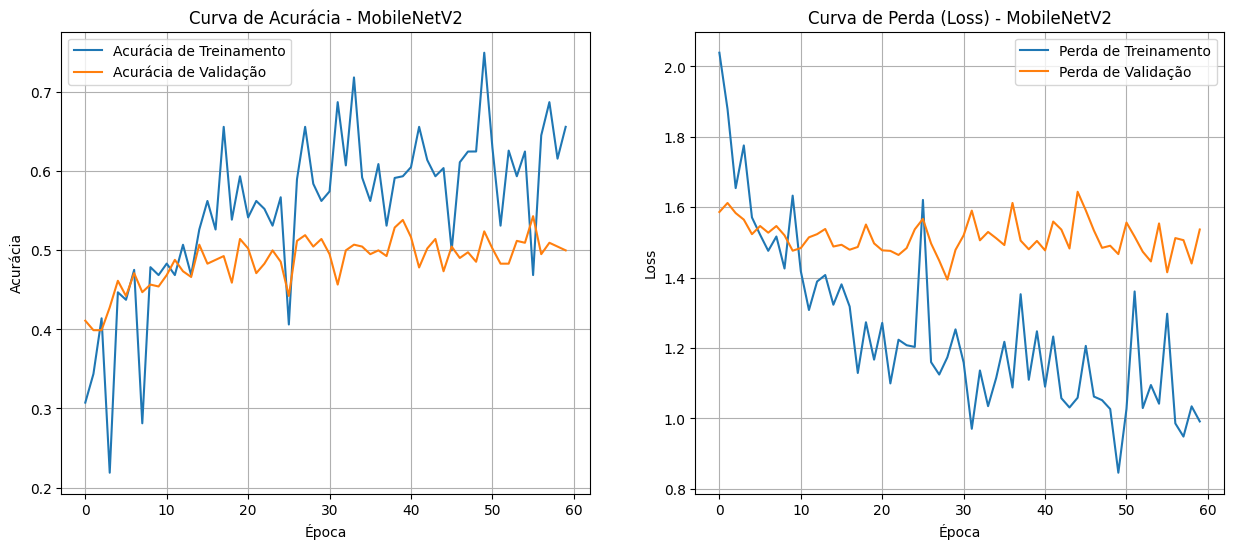


--- Geração das Matrizes de Confusão ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step


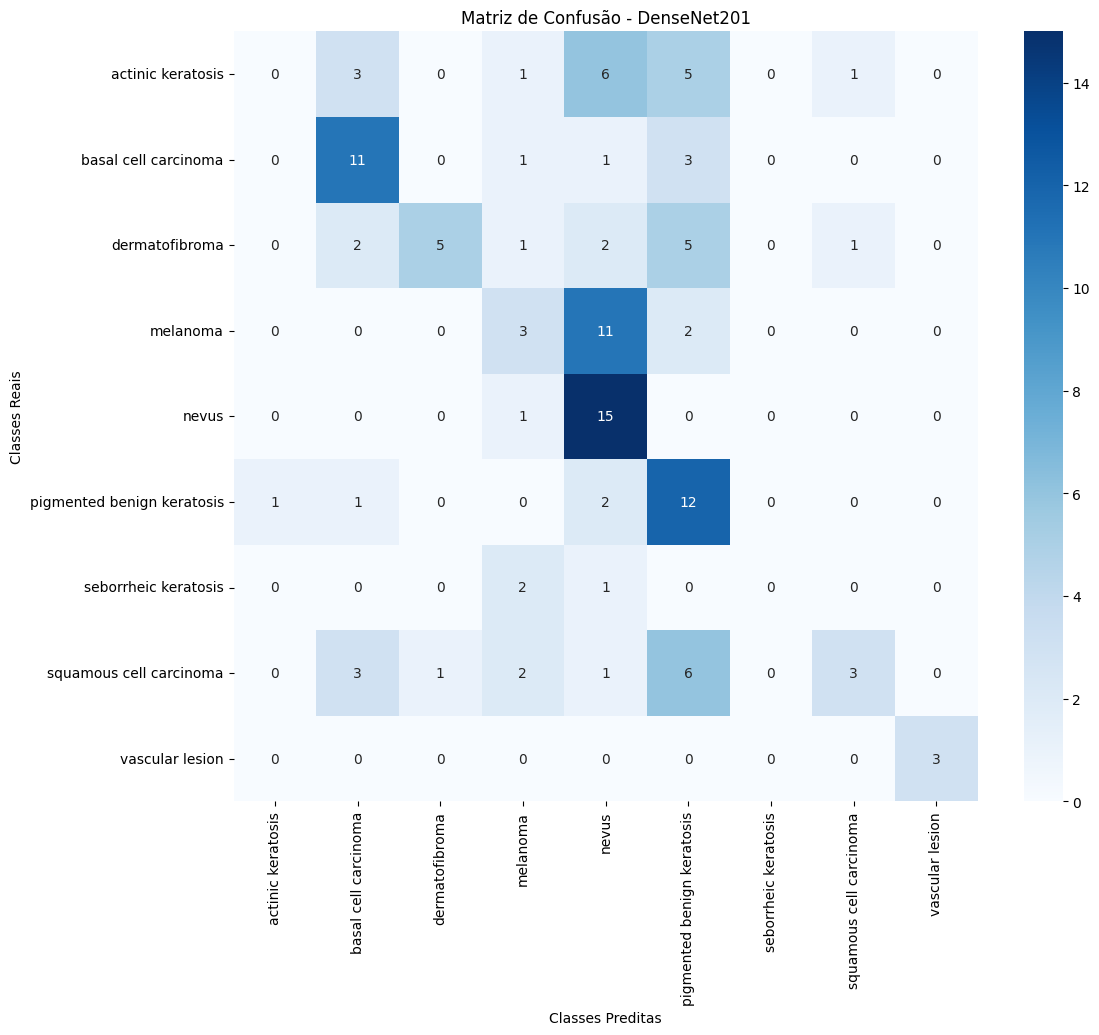

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


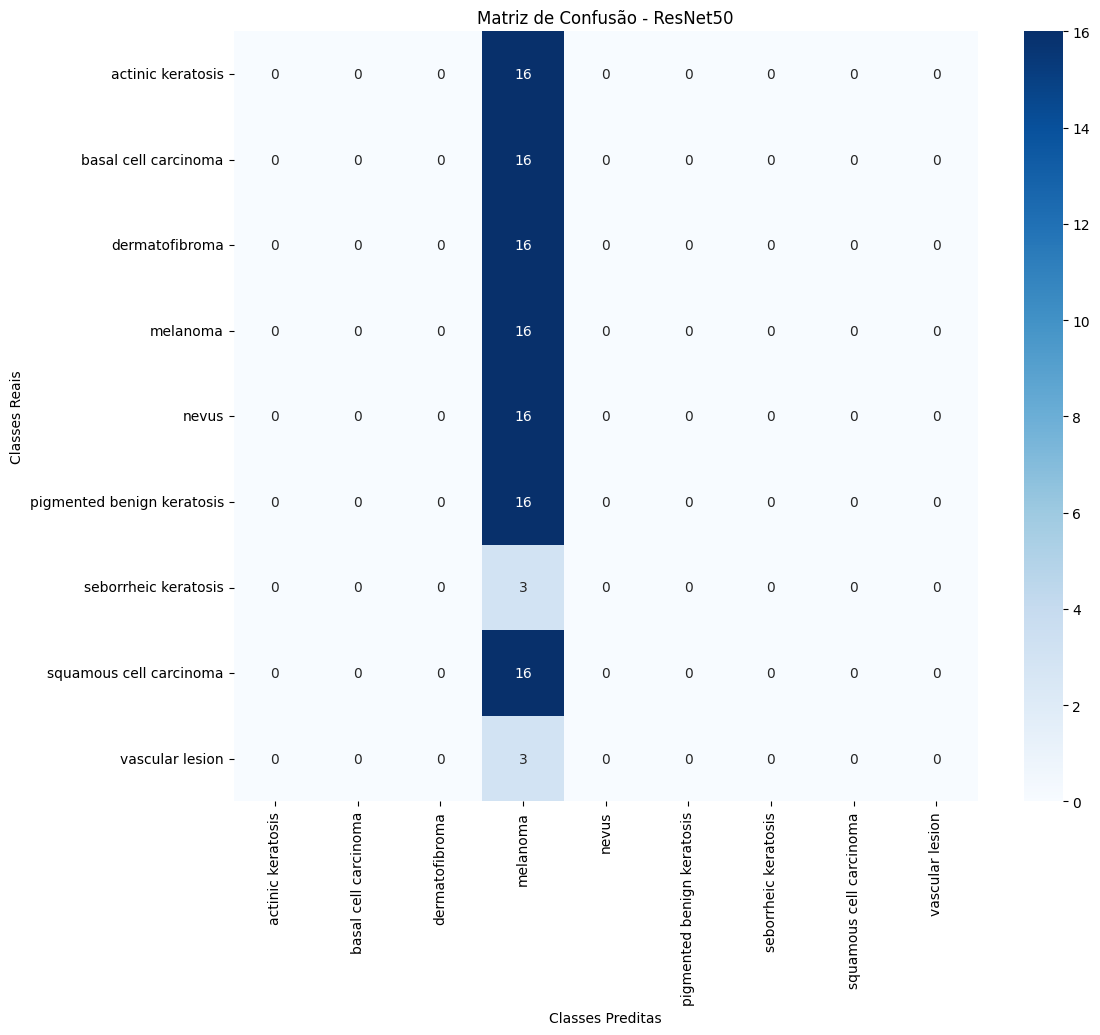

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


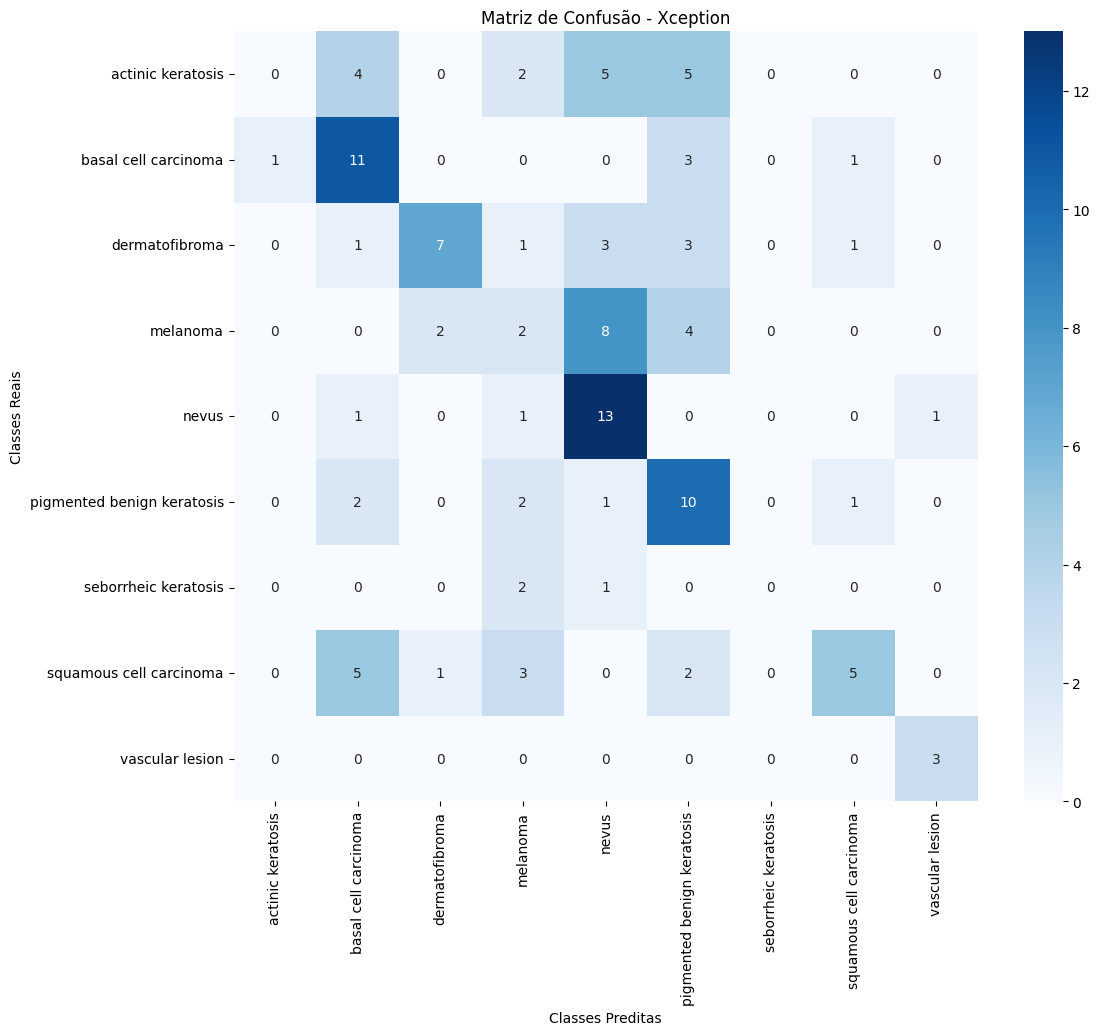

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step


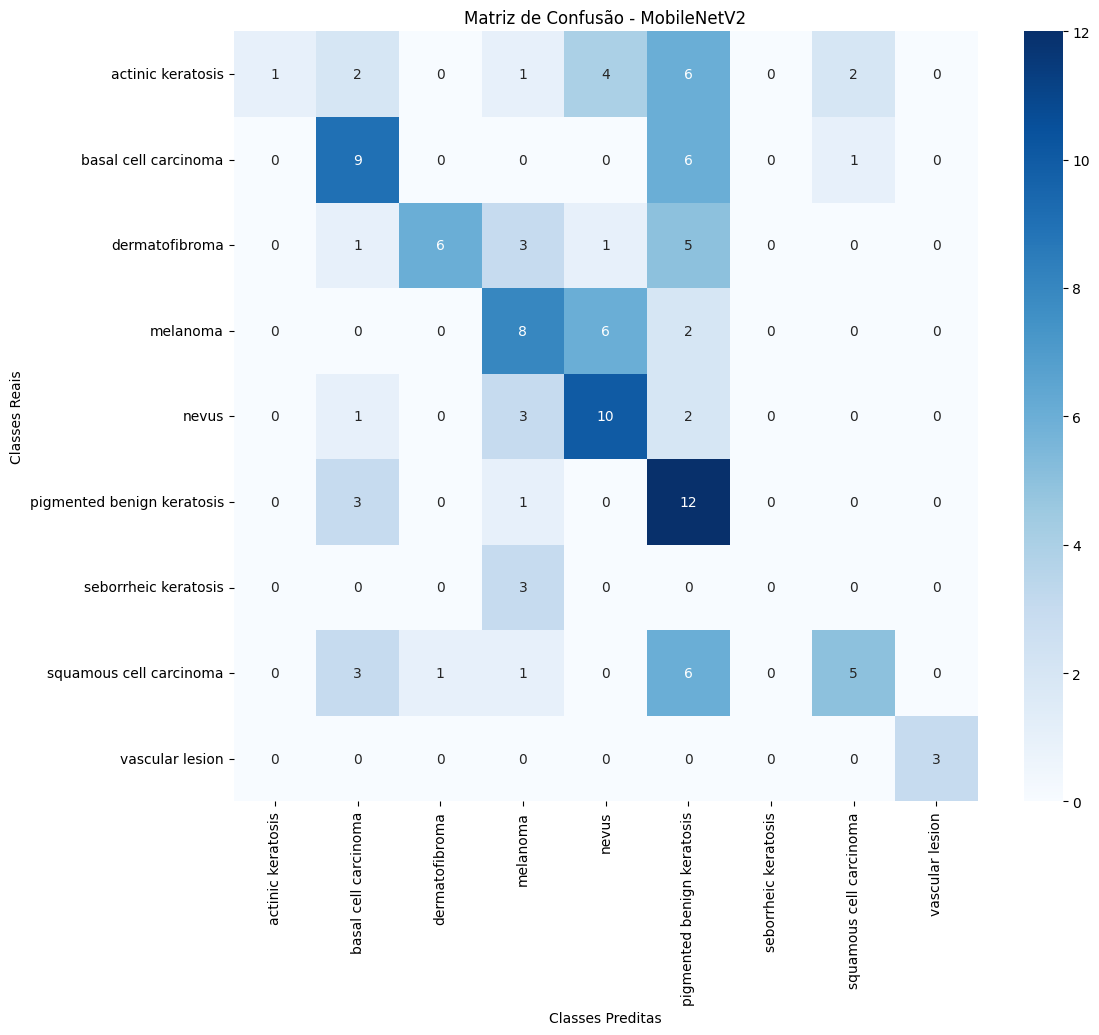


Processo de replicação do experimento e geração de figuras concluído.


In [ ]:
print("\n--- Geração das Curvas de Desempenho (Acurácia/Loss) ---")

for name, history in all_histories.items():
    plot_history(history, name)

print("\n--- Geração das Matrizes de Confusão ---")

for name, model in all_models.items():
    # Nota: O test_generator é reusado aqui
    plot_confusion_matrix(model, test_generator, class_names, name)

print("\nProcesso de replicação do experimento e geração de figuras concluído.")

In [ ]:
# 8. Grad-CAM (Mapas de Calor)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Cria um modelo que mapeia a entrada para a última camada convolucional
    # e para a saída final
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Computa o gradiente da classe predita em relação ao mapa de características
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradientes da classe de saída em relação ao mapa de características de saída
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vetor de pesos (pool_grads) - média global dos gradientes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplica cada canal do mapa de características pelo "peso" de importância do canal
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normaliza o heatmap entre 0 e 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Carrega a imagem original
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Redimensiona o heatmap para o tamanho da imagem original
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Aplica o colormap JET no heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superpõe a imagem original com o heatmap
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # Plota lado a lado
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()

# Helper para encontrar a última camada convolucional se não for especificada
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Verifica se é uma camada Conv2D ou similar (4D output)
        if len(layer.output_shape) == 4 and 'conv' in layer.name:
            return layer.name
    return None

# Exemplo de uso
try:
    # Tenta identificar o dicionário de modelos disponível
    available_models = {}
    if 'all_models' in globals():
        available_models = all_models
    elif 'results' in globals():
        available_models = {k: v['model'] for k, v in results.items()}

    if not available_models:
        print("⚠️ Nenhum modelo treinado encontrado na memória.")
    else:
        # Pegando uma imagem aleatória de teste (Melanoma)
        img_dir = os.path.join(DATA_DIR, 'Test', 'Melanoma')
        if os.path.exists(img_dir):
            img_name = os.listdir(img_dir)[0]
            img_path = os.path.join(img_dir, img_name)

            # Prepara a imagem
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            # Escolhe um modelo para visualizar
            model_name = list(available_models.keys())[0] # Pega o primeiro disponível
            model = available_models[model_name]

            # Define a camada alvo baseada no nome do modelo
            last_layer = None
            if 'DenseNet' in model.name: last_layer = 'conv5_block32_concat'
            elif 'ResNet' in model.name: last_layer = 'conv5_block3_out'
            elif 'Xception' in model.name: last_layer = 'block14_sepconv2_act'
            elif 'MobileNet' in model.name: last_layer = 'Out_relu'

            # Se não encontrou pelo nome, tenta buscar automaticamente
            if not last_layer:
                last_layer = find_last_conv_layer(model)

            if last_layer:
                print(f"Gerando Grad-CAM para {model_name} na imagem: {img_name}")
                print(f"Usando camada: {last_layer}")
                heatmap = make_gradcam_heatmap(img_array, model, last_layer)
                display_gradcam(img_path, heatmap)
            else:
                print(f"Não foi possível identificar a camada final para {model_name}. Defina 'last_layer' manualmente.")
        else:
            print(f"Diretório de teste não encontrado: {img_dir}")
except Exception as e:
    print(f"Erro ao gerar Grad-CAM: {e}")

⚠️ Nenhum modelo treinado encontrado na memória.
